In [ ]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants
from scipy import integrate
from scipy import optimize
# need to install rocket fft (via pip install rocket-fft) so that fft can be performed in numba

## Potentials

In [2]:
# Real units
hbar_real = constants.hbar
m_real = 1061 * constants.m_e
kB_real = constants.Boltzmann

# Natural units
hbar_nat = 1
m_nat = 1
kB_nat = 1

C:\Users\wu152\AppData\Roaming\Python\Python312\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


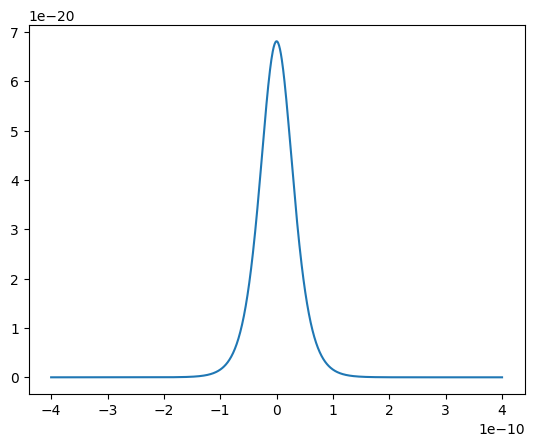

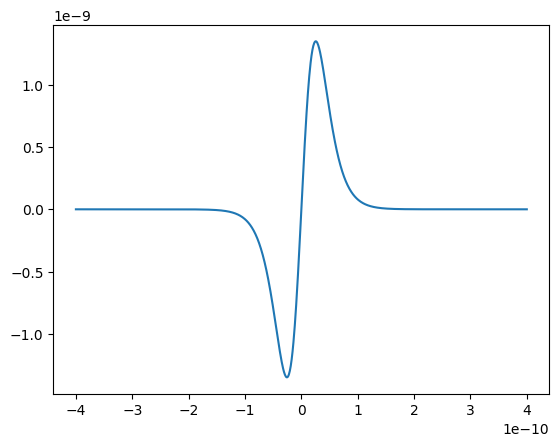

In [3]:
a = 0.734 * constants.physical_constants['Bohr radius'][0]
eV = constants.eV
V_0 = 0.425 * eV

@njit(nopython=True, fastmath=True)
def V_eckart(q):
    return V_0 / np.cosh(q / a)**2

@njit(nopython=True, fastmath=True)
def F_eckart(q):
    return 2 * V_0 * np.sinh(q / a) / (a * np.cosh(q / a)**3)

q_range = np.linspace(-4e-10,4e-10,1000)

plt.plot(q_range, V_eckart(q_range))
plt.show()
plt.plot(q_range, F_eckart(q_range))

C:\Users\wu152\AppData\Roaming\Python\Python312\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


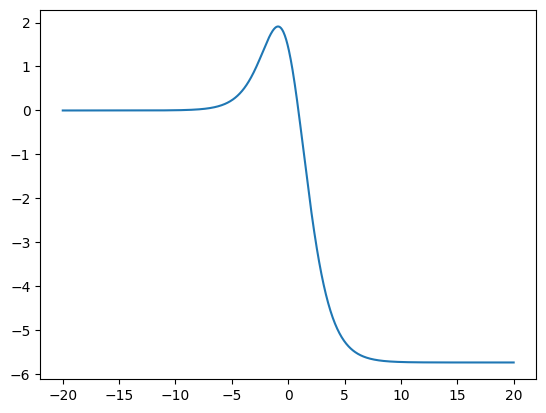

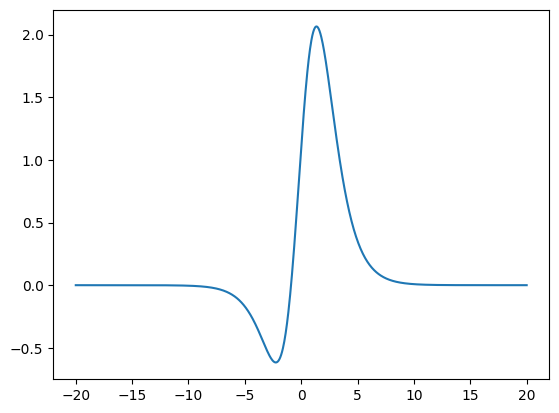

In [4]:
A = -18/np.pi
B = 13.5/np.pi
b = 8/np.sqrt(3*np.pi)


@njit(nopython=True, fastmath=True)
def V_asym_eckart(q):
    return A / (1+np.exp(-2*q/b)) + B / (np.cosh(q / b))**2

@njit(nopython=True, fastmath=True)
def F_asym_eckart(q):
    return -2 * A * np.exp(-2*q/b) / (b * (1+np.exp(-2*q/b))**2)  + 2 * B * np.sinh(q / b) / (b * np.cosh(q / b)**3)

q_range = np.linspace(-20,20,1000)

plt.plot(q_range, V_asym_eckart(q_range))
plt.show()
plt.plot(q_range, F_asym_eckart(q_range))

## Classical Transition State Theory

In [5]:
def TST_rate(beta, potential, q_min, q_max, m):
    res = optimize.minimize_scalar(lambda x: -potential(x), bounds=( q_min, q_max ), method='bounded')
    q_dag = res.x
    V_dag = potential(q_dag)

    rate = 1/np.sqrt(2*np.pi*m*beta) * np.exp(-beta*V_dag)
    
    return q_dag, rate


## Classical Rate

In [6]:
@njit(nopython=True, fastmath=True)
def verlet(x_init, v_init, N_time, delta_t, force, m):
    x_verlet = np.zeros(N_time)
    v_verlet = np.zeros(N_time)
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    for i in range(N_time - 1):
        f = force(x_verlet[i])
        x_new = x_verlet[i] + delta_t * v_verlet[i] + 0.5 * delta_t**2 * f / m
        f_new = force(x_new)
        v_new = v_verlet[i] + 0.5 * delta_t * (f + f_new) / m

        x_verlet[i + 1] = x_new
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

C:\Users\wu152\AppData\Roaming\Python\Python312\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [7]:
def Classical_Cfs(q_dagger, beta, N_samp, m, t_end=30e-15, delta_t=0.5e-15, force = F_eckart):
    C_time = np.arange(0, t_end, delta_t)
    N_time = len(C_time)
    C_func = np.zeros_like(C_time)
    
    for samp in tqdm(range(N_samp)):
        sigma_v = 1.0 / np.sqrt(beta * m)
        v_init = np.random.normal(0, sigma_v)
        q_verlet, v_verlet = verlet(q_dagger, v_init, N_time, delta_t, force, m)
        h = np.zeros_like(C_time)
        for i, q in enumerate(q_verlet):
            if q >= q_dagger:
                h[i] = 1

        C_func += v_init * h

    C_func /= N_samp
    return C_time, C_func

## Quantum Transition State Theory (Bennett&ndash;Chandler)

In [8]:
@njit(nopython=True, fastmath=True)
def normal_mode_frequencies(beta_n, n, hbar):
    omega_n = 1.0/(beta_n * hbar)
    k = np.arange(n)
    return 2.0 * omega_n * np.sin(np.pi * k / n)  # omega[0]=0

@njit(nopython=True, fastmath=True)
def fixed_mode_propagation(x, v, omega, delta_t):
    #Transform to normal coordinates
    Xk = np.fft.fft(x)
    Vk = np.fft.fft(v)

    Xk_next = np.empty_like(Xk)
    Vk_next = np.empty_like(Vk)

    # Centroid Fixed
    Xk_next[0] = Xk[0]
    Vk_next[0] = 0

    # Evolve the omgea>0 mode
    omega_pos = omega[1:]
    coswt = np.cos(omega_pos*delta_t)
    sinwt = np.sin(omega_pos*delta_t)
    Xk_pos = Xk[1:]
    Vk_pos = Vk[1:]
    Xk_next[1:] = Xk_pos * coswt + Vk_pos * (sinwt / omega_pos)
    Vk_next[1:] = Vk_pos * coswt - Xk_pos * (omega_pos * sinwt)
    
    # Transform back to real coordinates
    x_next = np.fft.ifft(Xk_next, axis=0).real
    v_next = np.fft.ifft(Vk_next, axis=0).real
    return x_next, v_next

In [9]:
@njit(nopython=True, fastmath=True)
def fixed_polymer_verlet(x_init, v_init, beta_n, N_time, delta_t, n, force, hbar, m):

    omega = normal_mode_frequencies(beta_n, n, hbar)

    x_verlet = np.zeros((N_time, n))
    v_verlet = np.zeros((N_time, n))
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    f = force(x_init)
    for i in range(N_time - 1):
        v_half = v_verlet[i] + 0.5 * delta_t * f / m                                # Propagate velocity half step by external potential
        x_mode, v_mode = fixed_mode_propagation(x_verlet[i], v_half, omega, delta_t)      # Propagate velocity and coordinate by mode vibration
        f_new = force(x_mode)
        v_new = v_mode + 0.5 * delta_t * f_new / m                                  # Propagate velocity half step by external potential

        f = f_new
        x_verlet[i + 1] = x_mode
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

In [10]:
@njit(nopython=True, fastmath=True)
def Polymer_BC_force(beta, n, q_mean, q_rad, N_samp, hbar, m, t_end=1e-14, delta_t = 1e-15, N_pre=10000, force = F_eckart):
    '''
        This code uses an Andersen thermostat to sample the thermal average of forces exerted on a ring polymer particle.

        beta: thermodynamic inverse temperature

        n: number of beads in the polymer

        q_mean: centroid position of the ring polymer

        q_rad: initial radius of gyration of the ring

        N_samp: number of samples

        t_end: time of polymer evolution

        delta_t: time step

        N_pre: number of steps in pre-equilibration

        force: force function

    '''
    N_time = int(t_end/delta_t)
    beta_n = beta/n

    q = q_mean + np.cos(2*np.pi *np.arange(n)/n)* q_rad

    for _ in range(N_pre):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = fixed_polymer_verlet(q, v_init, beta_n, N_time, delta_t, n, force, hbar, m)
        q = q_verlet[-1]
        q += q_mean - np.mean(q)
    
    all_forces = np.zeros(N_samp)
    
    for samp in range(N_samp):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = fixed_polymer_verlet(q, v_init, beta_n, N_time, delta_t, n, force, hbar, m)
        q = q_verlet[-1]
        q += q_mean - np.mean(q)
        all_forces[samp] = -np.mean(force(q))

    mean_forces = np.mean(all_forces)
    return mean_forces

## Ring Polymer Rate

In [11]:
@njit(nopython=True, fastmath=True)
def mode_propagation(x, v, omega, delta_t):
    #Transform to normal coordinates
    Xk = np.fft.fft(x)
    Vk = np.fft.fft(v)

    Xk_next = np.empty_like(Xk)
    Vk_next = np.empty_like(Vk)

    #Evolve the omega=0 mode
    Xk_next[0] = Xk[0] + Vk[0] * delta_t
    Vk_next[0] = Vk[0]

    # Evolve the omgea>0 mode
    omega_pos = omega[1:]
    coswt = np.cos(omega_pos*delta_t)
    sinwt = np.sin(omega_pos*delta_t)
    Xk_pos = Xk[1:]
    Vk_pos = Vk[1:]
    Xk_next[1:] = Xk_pos * coswt + Vk_pos * (sinwt / omega_pos)
    Vk_next[1:] = Vk_pos * coswt - Xk_pos * (omega_pos * sinwt)
    
    # Transform back to real coordinates
    x_next = np.fft.ifft(Xk_next, axis=0).real
    v_next = np.fft.ifft(Vk_next, axis=0).real
    return x_next, v_next

In [12]:
@njit(nopython=True, fastmath=True)
def polymer_verlet(x_init, v_init, beta_n, N_time, delta_t, n, force, hbar, m):

    omega = normal_mode_frequencies(beta_n, n, hbar)

    x_verlet = np.zeros((N_time, n))
    v_verlet = np.zeros((N_time, n))
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    f = force(x_init)
    for i in range(N_time - 1):
        v_half = v_verlet[i] + 0.5 * delta_t * f / m                                # Propagate velocity half step by external potential
        x_mode, v_mode = mode_propagation(x_verlet[i], v_half, omega, delta_t)      # Propagate velocity and coordinate by mode vibration
        f_new = force(x_mode)
        v_new = v_mode + 0.5 * delta_t * f_new / m                                  # Propagate velocity half step by external potential

        f = f_new
        x_verlet[i + 1] = x_mode
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

In [13]:
def Polymer_Cfs(q_dagger, q_rad, N_samp, beta, n, hbar, m, eq_t_end=1e-14, eq_delta_t=1e-15, t_end=3e-14, delta_t=0.5e-15, force = F_eckart, N_pre=10000):
    '''
        This code uses an Andersen thermostat with an initial Metropolis Monte Carlo pre-equilibration to sample the flux-side correlation function of a ring polymer particle.

        q_dagger: the dividing surface, also the centroid position of the ring polymer

        q_rad: initial radius of gyration of the ring

        N_samp: number of samples

        beta: thermodynamic inverse temperature

        n: number of beads in the polymer

        eq_t_end, eq_delta_t: time and time step of polymer evolution for equilibration

        t_end, delta_t: time and time step of polymer evolution for C_fs sampling

        potential: potential function

        force: force function

        step_size: size of Metropolis Monte-Carlo move

        N_pre: number of steps in pre-equilibration
    '''
    eq_N_time = int(eq_t_end/eq_delta_t)
    
    C_time = np.arange(0, t_end, delta_t)
    N_time = len(C_time)
    C_func = np.zeros(N_time)

    beta_n = beta/n

    q = q_dagger + np.cos(2*np.pi *np.arange(n)/n)* q_rad

    for _ in range(N_pre):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = fixed_polymer_verlet(q, v_init, beta_n, N_time, delta_t, n, force, hbar, m)
        q = q_verlet[-1]
        q += q_dagger - np.mean(q)
    
    for samp in tqdm(range(N_samp)):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_eq_verlet, v_eq_verlet = fixed_polymer_verlet(q, v_init, beta_n, eq_N_time, eq_delta_t, n, force, hbar, m)
        q = q_eq_verlet[-1]
        q += q_dagger - np.mean(q)

        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        v_0_bar = np.mean(v_init)
        q_verlet, v_verlet = polymer_verlet(q, v_init, beta_n, N_time, delta_t, n, force, hbar, m)
        q_t_bar = np.mean(q_verlet, axis = 1)
        h = np.zeros_like(q_t_bar)
        for i, q_bar in enumerate(q_t_bar):
            if q_bar >= q_dagger:
                h[i] = 1

        C_func += v_0_bar * h

    C_func /= N_samp
    return C_time, C_func

## Symmetric Eckart

In [14]:
T_range_sym = [200,300,600,1000,1500,2000]

### Classical Transition State Theory

In [15]:
q_dag_sym_class = []
k_TST_sym = []
for i, T in enumerate(T_range_sym):
    beta = 1/(kB_real * T)
    q_dag, k_TST = TST_rate(beta, V_eckart, -1e-20, 1e-20, m_real)
    q_dag_sym_class.append(q_dag)
    k_TST_sym.append(k_TST)

    print(f'------Temperature: {T:.1f} K------')
    print(f"q‡ = {q_dag*1e10:.6f} Å")
    print(f"k_TST = {k_TST:.6e}")
    print('--------------------------------')

------Temperature: 200.0 K------
q‡ = -0.000000 Å
k_TST = 1.316242e-08
--------------------------------
------Temperature: 300.0 K------
q‡ = -0.000000 Å
k_TST = 5.987208e-05
--------------------------------
------Temperature: 600.0 K------
q‡ = -0.000000 Å
k_TST = 3.144722e-01
--------------------------------
------Temperature: 1000.0 K------
q‡ = -0.000000 Å
k_TST = 1.087536e+01
--------------------------------
------Temperature: 1500.0 K------
q‡ = -0.000000 Å
k_TST = 6.893789e+01
--------------------------------
------Temperature: 2000.0 K------
q‡ = -0.000000 Å
k_TST = 1.810972e+02
--------------------------------


### Classical Rate

In [16]:
C_time_sym_class = []
C_func_sym_class = []

for i, T in enumerate(T_range_sym):
    beta = 1/(kB_real * T)

    C_time, C_func = Classical_Cfs(
        q_dag_sym_class[i], beta, 100000, m_real
    )
    print()

    C_time_sym_class.append(C_time)
    C_func_sym_class.append(C_func)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:03<00:00, 32994.75it/s]


100%|██████████| 100000/100000 [00:02<00:00, 37413.22it/s]


100%|██████████| 100000/100000 [00:02<00:00, 37818.91it/s]


100%|██████████| 100000/100000 [00:02<00:00, 38717.92it/s]


100%|██████████| 100000/100000 [00:02<00:00, 38983.85it/s]


100%|██████████| 100000/100000 [00:02<00:00, 38576.15it/s]

------Temperature: 200.0 K------
k_cl = 1.315697e-08
--------------------------------
------Temperature: 300.0 K------
k_cl = 5.985672e-05
--------------------------------
------Temperature: 600.0 K------
k_cl = 3.127963e-01
--------------------------------
------Temperature: 1000.0 K------
k_cl = 1.079952e+01
--------------------------------
------Temperature: 1500.0 K------
k_cl = 6.930619e+01
--------------------------------
------Temperature: 2000.0 K------
k_cl = 1.805902e+02
--------------------------------


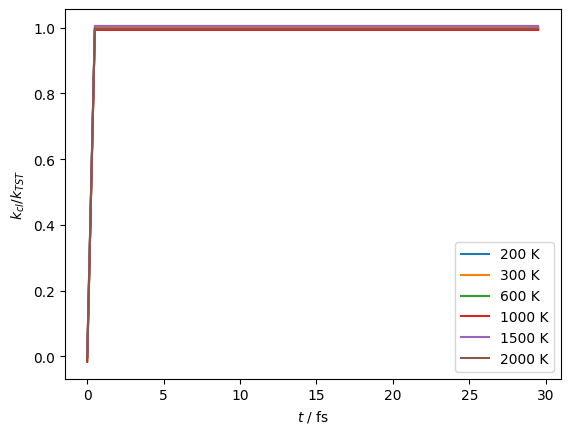

In [17]:
k_cl_sym = []
for i, T in enumerate(T_range_sym):
    beta = 1/(kB_real * T)
    C_time = C_time_sym_class[i] * 1e15
    C_func = C_func_sym_class[i]
    C_den = np.sqrt(1.0 / (2 * np.pi * m_real * beta))
    k_TST = k_TST_sym[i]
    k_cl = k_TST * C_func[-1] / C_den
    k_cl_sym.append(k_cl)
    plt.plot(C_time, C_func/C_den, label=f'{T} K')
    print(f'------Temperature: {T:.1f} K------')
    print(f"k_cl = {k_cl:.6e}")
    print('--------------------------------')
plt.xlabel(r'$t$ / $\mathrm{fs}$')
plt.ylabel(r'$k_{cl}/k_{TST}$')
plt.legend()

### Quantum Transition State Theory (Bennett&ndash;Chandler)

In [20]:
n_list_QTST_sym = [128, 100, 64, 64, 64, 32]


q_grid_sym = np.concatenate((
        np.arange(-5e-10, -2e-10, 1e-10),
        np.arange(-2e-10, -9e-11, 1e-11),
        np.arange(-9e-11, 5e-11, 3e-12)
    ))

In [21]:
dFdq_list_sym = []

for i, T in enumerate(T_range_sym):
    beta = 1/(kB_real * T)
    n = n_list_QTST_sym[i]

    dFdq = np.empty_like(q_grid_sym)
    for j, q in enumerate(tqdm(q_grid_sym, desc="Sampling mean force")):
        dFdq[j] = Polymer_BC_force(
            beta, n, q, 3e-11, 100000, hbar_real, m_real
        )

    dFdq_list_sym.append(dFdq)

np.save('Results/q_grid_sym.npy', q_grid_sym)
np.save('Results/dFdq_list_sym.npy', dFdq_list_sym)

Sampling mean force: 100%|██████████| 62/62 [04:19<00:00,  4.19s/it]


In [22]:
q_grid_sym = np.load('Results/q_grid_sym.npy')
dFdq_list_sym = np.load('Results/dFdq_list_sym.npy')

F_profile_sym = []
k_QTST_sym = []
kappa_QTST_sym = []
q_daggers_sym = np.zeros_like(T_range_sym)

for i, dFdq in enumerate(dFdq_list_sym):
    T = T_range_sym[i]
    beta = 1/(kB_real * T)
    # Build full F(q) by integration from left reference
    F_profile = integrate.cumulative_trapezoid(dFdq, q_grid_sym, initial=0.0)

    F_profile_sym.append(F_profile)

    # Activation free energy (integrate only up to q=0) and rate
    q_dagger = q_daggers_sym[i]
    i0 = np.argmin(np.abs(q_grid_sym - q_dagger))
    DeltaF = F_profile[i0] - F_profile[0]
    k_QTST = np.exp(-beta * DeltaF) / np.sqrt(2.0 * np.pi * m_real * beta)

    k_QTST_sym.append(k_QTST)
    k_cl = k_cl_sym[i]
    kappa = k_QTST / k_cl
    kappa_QTST_sym.append(kappa)

    print(f'------Temperature: {T:.1f} K------')
    print(f"ΔF‡ (eV) = {DeltaF/constants.eV:.6f}")
    print(f"k_QTST = {k_QTST:.6e}")
    print(f"kappa = {kappa:.6e}")
    print('--------------------------------')

------Temperature: 200.0 K------
ΔF‡ (eV) = 0.302157
k_QTST = 1.639991e-05
kappa = 1.246480e+03
--------------------------------
------Temperature: 300.0 K------
ΔF‡ (eV) = 0.354709
k_QTST = 9.079364e-04
kappa = 1.516849e+01
--------------------------------
------Temperature: 600.0 K------
ΔF‡ (eV) = 0.394080
k_QTST = 5.718761e-01
kappa = 1.828270e+00
--------------------------------
------Temperature: 1000.0 K------
ΔF‡ (eV) = 0.406478
k_QTST = 1.348312e+01
kappa = 1.248492e+00
--------------------------------
------Temperature: 1500.0 K------
ΔF‡ (eV) = 0.412651
k_QTST = 7.584876e+01
kappa = 1.094401e+00
--------------------------------
------Temperature: 2000.0 K------
ΔF‡ (eV) = 0.415510
k_QTST = 1.913484e+02
kappa = 1.059572e+00
--------------------------------


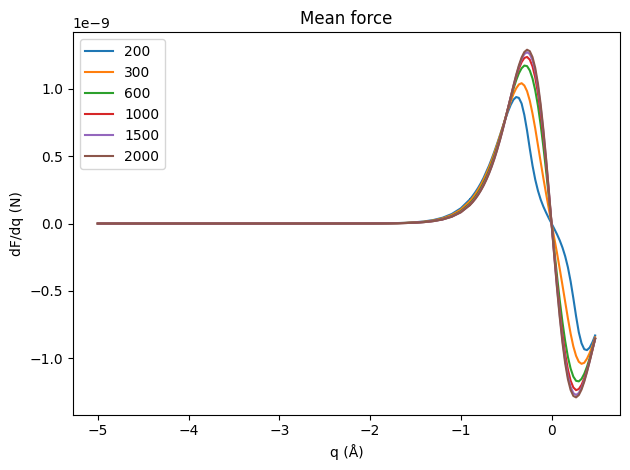

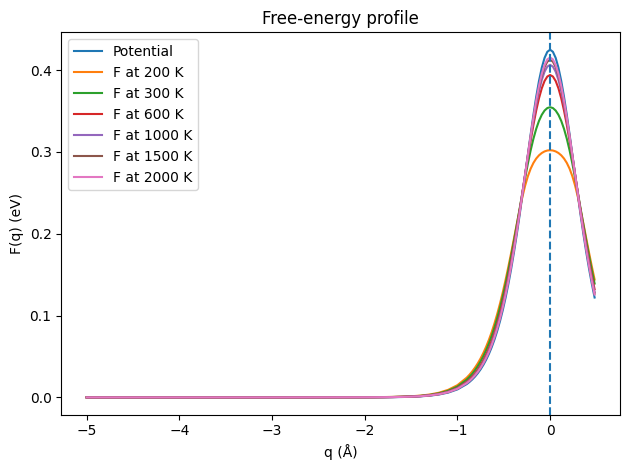

In [23]:
for i, T in enumerate(T_range_sym):
    dFdq = dFdq_list_sym[i]
    plt.plot(q_grid_sym*1e10, dFdq, label=f'{T}')
plt.xlabel("q (Å)"); plt.ylabel("dF/dq (N)")
plt.title("Mean force")
plt.tight_layout()
plt.legend()
plt.show()

plt.plot(q_grid_sym*1e10, V_eckart(q_grid_sym)/constants.eV, label='Potential')
for i, T in enumerate(T_range_sym):
    F_profile = F_profile_sym[i]
    plt.plot(q_grid_sym*1e10, F_profile/constants.eV, label=f'F at {T} K')
plt.axvline(0, ls='--')
plt.xlabel("q (Å)"); plt.ylabel("F(q) (eV)")
plt.title("Free-energy profile")
plt.tight_layout()
plt.legend()
plt.show()

### Ring Polymer

In [24]:
n_list_RPMD_sym = [128, 100, 64, 64, 64, 32]
q_dagger_test_sym = [-4.5e-11, -3e-11, -1.5e-11, 0, 1.5e-11, 3e-11]

C_time_poly_sym = []
C_func_poly_sym = []

for i, T in enumerate(T_range_sym):
    C_time_poly_sym.append([])
    C_func_poly_sym.append([])
    for q_dagger in q_dagger_test_sym:
        beta = 1/(kB_real * T)
        n = n_list_RPMD_sym[i]

        C_time, C_func = Polymer_Cfs(
            q_dagger, 3e-11, 100000, beta, n, hbar_real, m_real
        )

        C_time_poly_sym[i].append(C_time)
        C_func_poly_sym[i].append(C_func)

np.save('Results/C_time_poly_sym.npy', C_time_poly_sym)
np.save('Results/C_func_poly_sym.npy', C_func_poly_sym)

100%|██████████| 100000/100000 [00:36<00:00, 2733.19it/s]


------Temperature: 200.0 K------
k_RPMD = 1.567607e-05
kappa = 1.191465e+03
--------------------------------
------Temperature: 300.0 K------
k_RPMD = 8.973287e-04
kappa = 1.499128e+01
--------------------------------
------Temperature: 600.0 K------
k_RPMD = 5.748543e-01
kappa = 1.837791e+00
--------------------------------
------Temperature: 1000.0 K------
k_RPMD = 1.339741e+01
kappa = 1.240555e+00
--------------------------------
------Temperature: 1500.0 K------
k_RPMD = 7.556259e+01
kappa = 1.090272e+00
--------------------------------
------Temperature: 2000.0 K------
k_RPMD = 1.923401e+02
kappa = 1.065064e+00
--------------------------------


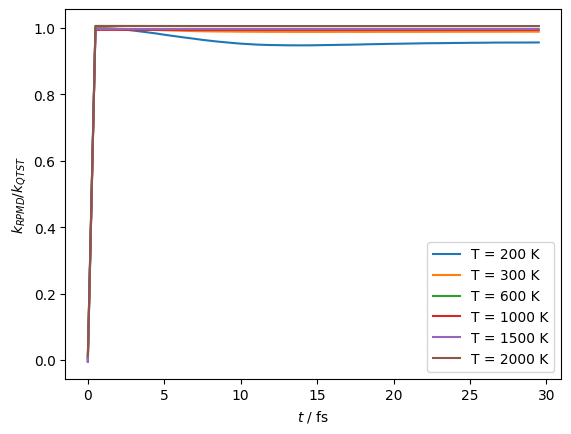

In [25]:
k_RPMD_sym = np.zeros(len(T_range_sym))
kappa_RPMD_sym = np.zeros(len(T_range_sym))

C_time_poly_sym = np.load('Results/C_time_poly_sym.npy')
C_func_poly_sym = np.load('Results/C_func_poly_sym.npy')

for i, T in enumerate(T_range_sym):
    dFdq = dFdq_list_sym[i]
    F_profile = integrate.cumulative_trapezoid(dFdq, q_grid_sym, initial=0.0)
    beta = 1/(kB_real * T)
    
    C_den = np.sqrt(1.0 / (2.0 * np.pi * m_real * beta))

    q_dagger = q_daggers_sym[i]

    j0 = np.argmin(np.abs(q_dagger_test_sym - q_dagger))
    
    C_time = C_time_poly_sym[i, j0] * 1e15
    C_func = C_func_poly_sym[i, j0]

    i0 = np.argmin(np.abs(q_grid_sym - q_dagger))
    DeltaF = F_profile[i0] - F_profile[0]
    k_QTST = np.exp(-beta * DeltaF) / np.sqrt(2.0 * np.pi * m_real * beta)
    
    k_RPMD = k_QTST * C_func[-1] / C_den
    k_RPMD_sym[i] = k_RPMD
    k_cl = k_cl_sym[i]
    kappa = k_RPMD / k_cl
    kappa_RPMD_sym[i] = kappa
    plt.plot(C_time, C_func/C_den, label=f'T = {T} K')
    print(f'------Temperature: {T:.1f} K------')
    print(f"k_RPMD = {k_RPMD:.6e}")
    print(f"kappa = {kappa:.6e}")
    print('--------------------------------')
plt.xlabel(r'$t$ / $\mathrm{fs}$')
plt.ylabel(r'$k_{RPMD}/k_{QTST}$')
plt.legend()
plt.show()

------Temperature: 200.0 K------
k_RPMD = 1.558015e-05
kappa = 1.184174e+03
k_RPMD = 2.009908e-05
kappa = 1.527637e+03
k_RPMD = 1.691861e-05
kappa = 1.285905e+03
k_RPMD = 1.567607e-05
kappa = 1.191465e+03
k_RPMD = 1.716269e-05
kappa = 1.304456e+03
k_RPMD = 2.034892e-05
kappa = 1.546626e+03
--------------------------------


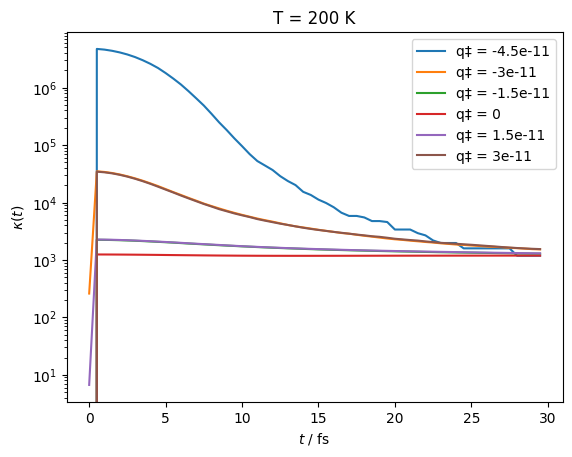

------Temperature: 300.0 K------
k_RPMD = 9.761606e-04
kappa = 1.630829e+01
k_RPMD = 9.227992e-04
kappa = 1.541680e+01
k_RPMD = 9.159867e-04
kappa = 1.530299e+01
k_RPMD = 8.973287e-04
kappa = 1.499128e+01
k_RPMD = 9.255500e-04
kappa = 1.546276e+01
k_RPMD = 8.740237e-04
kappa = 1.460193e+01
--------------------------------


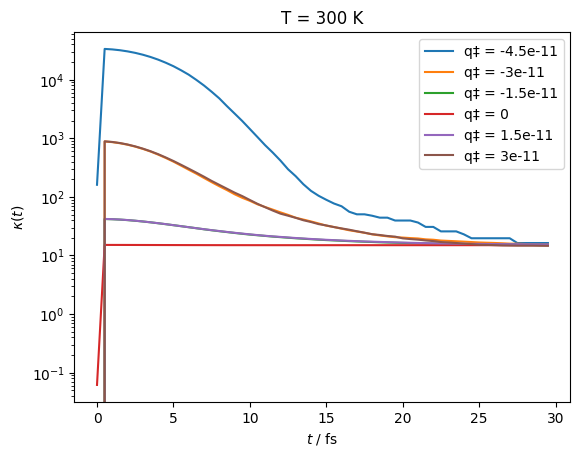

------Temperature: 600.0 K------
k_RPMD = 6.642603e-01
kappa = 2.123619e+00
k_RPMD = 5.568177e-01
kappa = 1.780129e+00
k_RPMD = 5.759432e-01
kappa = 1.841272e+00
k_RPMD = 5.748543e-01
kappa = 1.837791e+00
k_RPMD = 5.598693e-01
kappa = 1.789885e+00
k_RPMD = 5.047206e-01
kappa = 1.613576e+00
--------------------------------


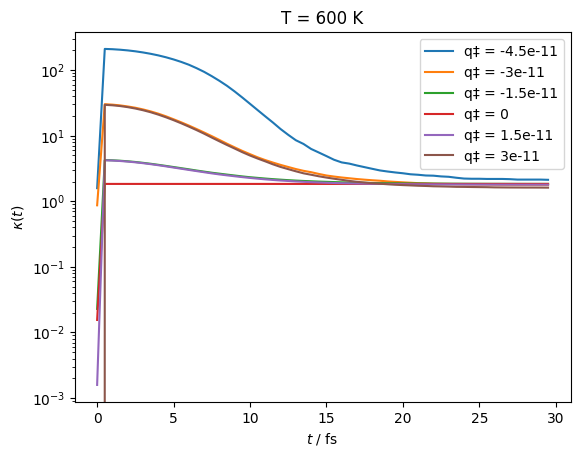

------Temperature: 1000.0 K------
k_RPMD = 1.409687e+01
kappa = 1.305323e+00
k_RPMD = 1.385218e+01
kappa = 1.282666e+00
k_RPMD = 1.336142e+01
kappa = 1.237223e+00
k_RPMD = 1.339741e+01
kappa = 1.240555e+00
k_RPMD = 1.359720e+01
kappa = 1.259055e+00
k_RPMD = 1.392038e+01
kappa = 1.288981e+00
--------------------------------


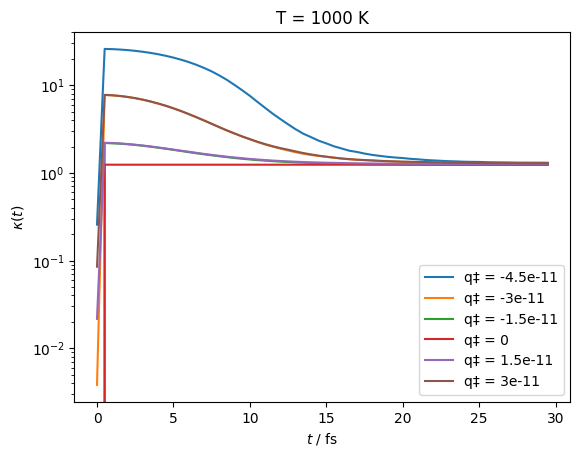

------Temperature: 1500.0 K------
k_RPMD = 7.698611e+01
kappa = 1.110811e+00
k_RPMD = 7.825355e+01
kappa = 1.129099e+00
k_RPMD = 7.517009e+01
kappa = 1.084609e+00
k_RPMD = 7.556259e+01
kappa = 1.090272e+00
k_RPMD = 7.607008e+01
kappa = 1.097594e+00
k_RPMD = 7.637371e+01
kappa = 1.101975e+00
--------------------------------


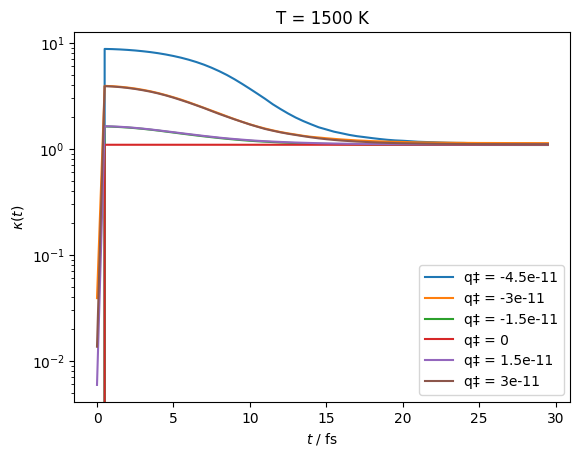

------Temperature: 2000.0 K------
k_RPMD = 1.914816e+02
kappa = 1.060310e+00
k_RPMD = 1.899891e+02
kappa = 1.052045e+00
k_RPMD = 1.920258e+02
kappa = 1.063323e+00
k_RPMD = 1.923401e+02
kappa = 1.065064e+00
k_RPMD = 1.909099e+02
kappa = 1.057144e+00
k_RPMD = 1.922897e+02
kappa = 1.064784e+00
--------------------------------


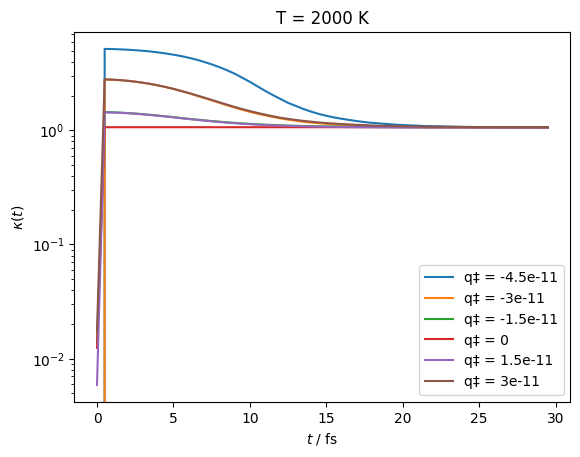

In [26]:
k_RPMD_all_sym = np.zeros((len(T_range_sym), len(q_dagger_test_sym)))
kappa_RPMD_all_sym = np.zeros((len(T_range_sym), len(q_dagger_test_sym)))


for i, T in enumerate(T_range_sym):
    dFdq = dFdq_list_sym[i]
    F_profile = integrate.cumulative_trapezoid(dFdq, q_grid_sym, initial=0.0)
    beta = 1/(kB_real * T)
    
    C_den = np.sqrt(1.0 / (2.0 * np.pi * m_real * beta))
    print(f'------Temperature: {T:.1f} K------')
    for j, q_dagger in enumerate(q_dagger_test_sym):
        C_time = C_time_poly_sym[i, j] * 1e15
        C_func = C_func_poly_sym[i, j]

        i0 = np.argmin(np.abs(q_grid_sym - q_dagger))
        DeltaF = F_profile[i0] - F_profile[0]
        k_QTST = np.exp(-beta * DeltaF) / np.sqrt(2.0 * np.pi * m_real * beta)
        
        k_RPMD = k_QTST * C_func[-1] / C_den
        k_RPMD_all_sym[i, j] = k_RPMD
        k_cl = k_cl_sym[i]
        kappa = k_RPMD / k_cl
        kappa_RPMD_all_sym[i, j] = kappa

        kappa_t = k_QTST * C_func / (C_den * k_cl)
        plt.plot(C_time, kappa_t, label=f'q‡ = {q_dagger}')
        print(f"k_RPMD = {k_RPMD:.6e}")
        print(f"kappa = {kappa:.6e}")
    print('--------------------------------')
    plt.xlabel(r'$t$ / $\mathrm{fs}$')
    plt.ylabel(r'$\kappa(t)$')
    plt.title(f'T = {T} K')
    plt.legend()
    plt.yscale('log')
    plt.show()


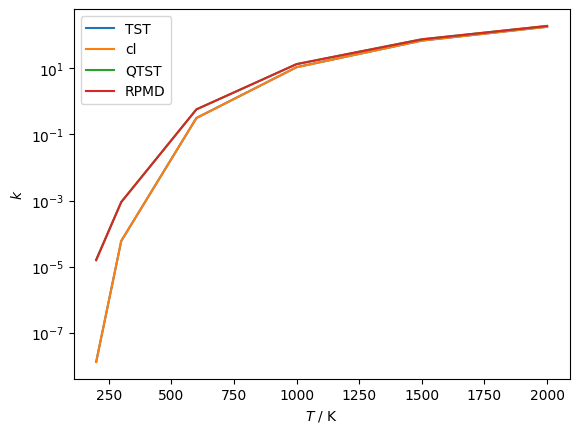

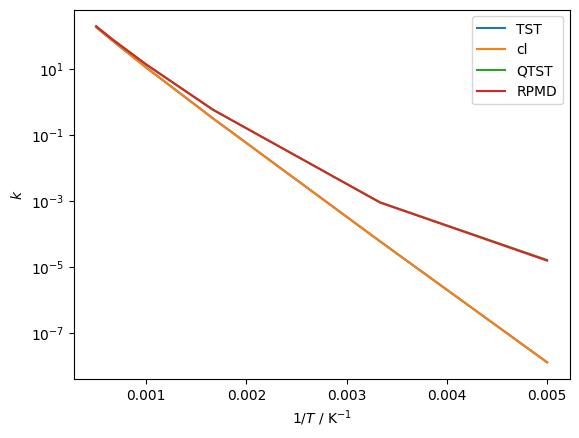

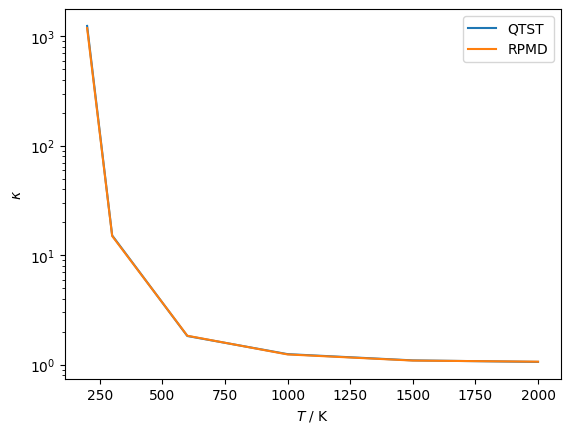

In [27]:
T_range_sym = np.array(T_range_sym)
plt.plot(T_range_sym, k_TST_sym, label='TST')
plt.plot(T_range_sym, k_cl_sym, label='cl')
plt.plot(T_range_sym, k_QTST_sym, label='QTST')
plt.plot(T_range_sym, k_RPMD_sym, label='RPMD')
plt.yscale('log')
plt.xlabel(r"$T$ / $\mathrm{K}$")
plt.ylabel(r"$k$")
plt.legend()
plt.show()

plt.plot(1/T_range_sym, k_TST_sym, label='TST')
plt.plot(1/T_range_sym, k_cl_sym, label='cl')
plt.plot(1/T_range_sym, k_QTST_sym, label='QTST')
plt.plot(1/T_range_sym, k_RPMD_sym, label='RPMD')
plt.yscale('log')
plt.xlabel(r"$1/T$ / $\mathrm{K}^{-1}$")
plt.ylabel(r"$k$")
plt.legend()
plt.show()

plt.plot(T_range_sym, kappa_QTST_sym, label='QTST')
plt.plot(T_range_sym, kappa_RPMD_sym, label='RPMD')
plt.yscale('log')
plt.ylabel(r'$\kappa$')
plt.xlabel(r"$T$ / $\mathrm{K}$")
plt.legend()

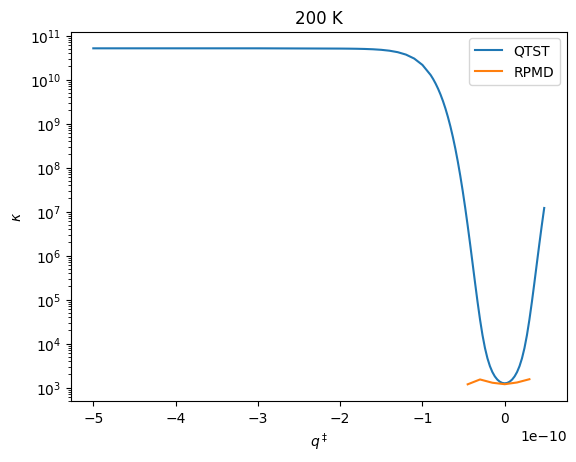

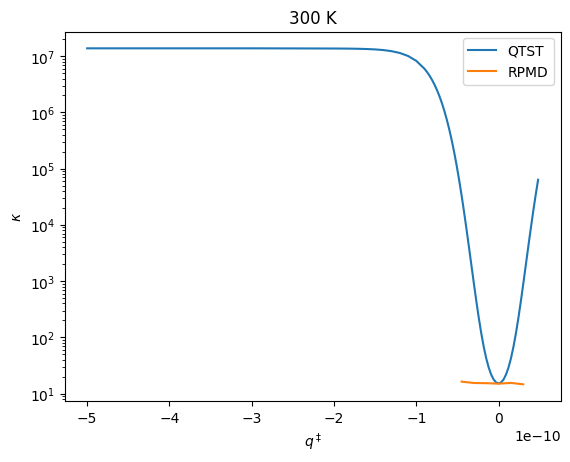

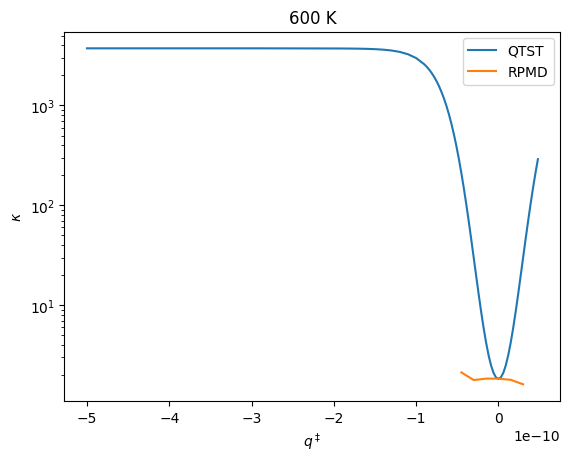

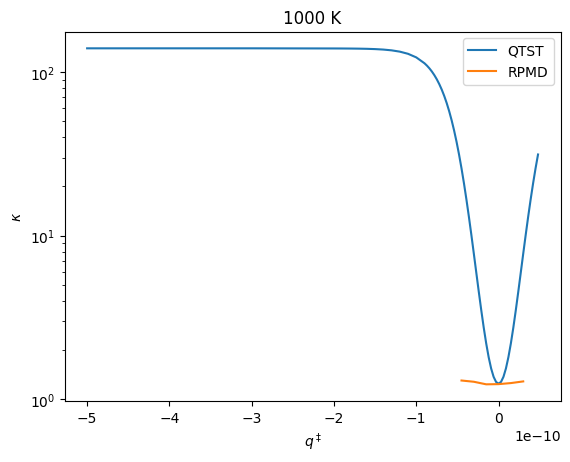

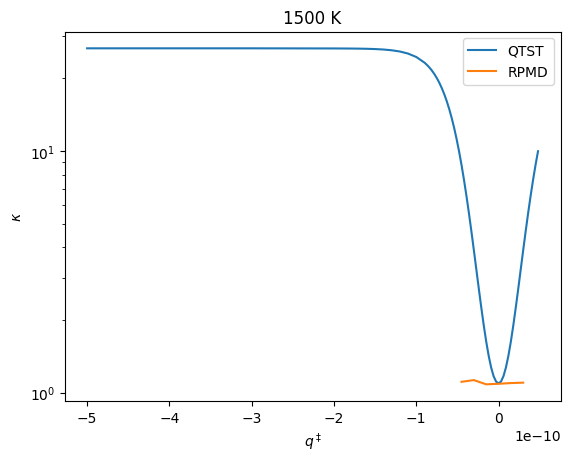

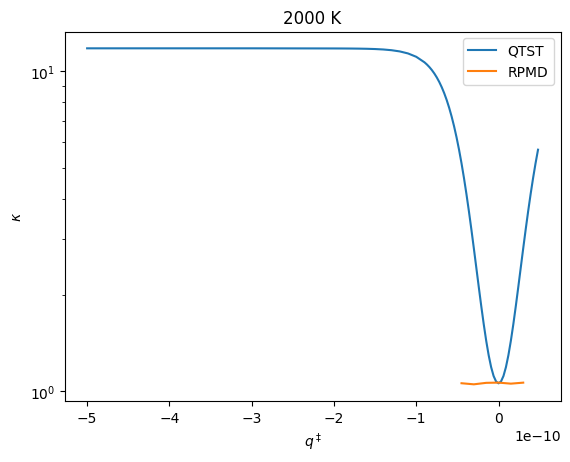

In [28]:
for i, dFdq in enumerate(dFdq_list_sym):
    T = T_range_sym[i]
    beta = 1/(kB_real * T)

    F_profile = F_profile_sym[i]

    DeltaF_qdag = F_profile - F_profile[0]
    k_QTST_qdag = np.exp(-beta * DeltaF_qdag) / np.sqrt(2.0 * np.pi * m_real * beta)

    k_RPMD = k_RPMD_sym[i]
    k_cl = k_cl_sym[i]
    kappa_QTST = k_QTST_qdag / k_cl
    kappa_RPMD = k_RPMD / k_cl
    plt.plot(q_grid_sym, kappa_QTST, label='QTST')
    plt.plot(q_dagger_test_sym, kappa_RPMD_all_sym[i], label='RPMD')
    plt.ylabel(r'$\kappa$')
    plt.xlabel(r'$q^\ddagger$')
    plt.title(f'{T} K')
    plt.yscale('log')
    plt.legend()
    plt.show()


## Asymmetric Eckart

In [29]:
beta_range_asym = np.array([2,4,8,10,12])

### Classical Transition State Theory

In [30]:
q_dag_class_asym = []
k_TST_asym = []
for i, beta in enumerate(beta_range_asym):
    q_dag, k_TST = TST_rate(beta, V_asym_eckart, -0.91, -0.90, m_nat)
    q_dag_class_asym.append(q_dag)
    k_TST_asym.append(k_TST)

    print(f'--------- beta = {beta:.1f} ---------')
    print(f"q‡ = {q_dag:.6f}")
    print(f"k_TST = {k_TST:.6e}")
    print('--------------------------------')

--------- beta = 2.0 ---------
q‡ = -0.903129
k_TST = 6.187459e-03
--------------------------------
--------- beta = 4.0 ---------
q‡ = -0.903129
k_TST = 9.596539e-05
--------------------------------
--------- beta = 8.0 ---------
q‡ = -0.903129
k_TST = 3.264632e-08
--------------------------------
--------- beta = 10.0 ---------
q‡ = -0.903129
k_TST = 6.404665e-10
--------------------------------
--------- beta = 12.0 ---------
q‡ = -0.903129
k_TST = 1.282399e-11
--------------------------------


### Classical Rate

In [31]:
C_time_asym_class = []
C_func_asym_class = []

for i, beta in enumerate(beta_range_asym):

    C_time, C_func = Classical_Cfs(
        q_dag_class_asym[i], beta, 100000, m_nat, t_end=15, delta_t=0.2, force = F_asym_eckart
    )
    print()

    C_time_asym_class.append(C_time)
    C_func_asym_class.append(C_func)

100%|██████████| 100000/100000 [00:03<00:00, 27844.01it/s]


100%|██████████| 100000/100000 [00:03<00:00, 29015.27it/s]


100%|██████████| 100000/100000 [00:03<00:00, 30597.17it/s]


100%|██████████| 100000/100000 [00:03<00:00, 30891.62it/s]


100%|██████████| 100000/100000 [00:03<00:00, 31764.93it/s]

0.006187459121780226
--------- beta = 2.0 ---------
k_cl = 6.186088e-03
--------------------------------
9.596538713614833e-05
--------- beta = 4.0 ---------
k_cl = 9.608218e-05
--------------------------------
3.264631534059965e-08
--------- beta = 8.0 ---------
k_cl = 3.244244e-08
--------------------------------
6.40466530818529e-10
--------- beta = 10.0 ---------
k_cl = 6.392390e-10
--------------------------------
1.2823987654209586e-11
--------- beta = 12.0 ---------
k_cl = 1.273291e-11
--------------------------------


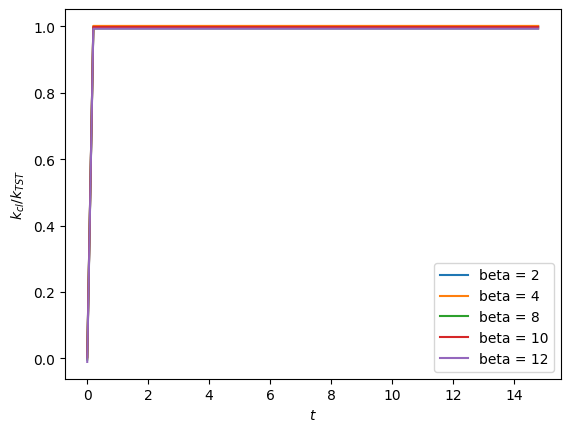

In [ ]:
k_cl_asym = []
for i, beta in enumerate(beta_range_asym):
    C_time = C_time_asym_class[i]
    C_func = C_func_asym_class[i]
    C_den = np.sqrt(1.0 / (2 * np.pi * m_nat * beta))
    k_TST = k_TST_asym[i]
    k_cl = k_TST * C_func[-1] / C_den
    k_cl_asym.append(k_cl)
    plt.plot(C_time, C_func/C_den, label=f'beta = {beta}')
    print(f'--------- beta = {beta:.1f} ---------')
    print(f"k_cl = {k_cl:.6e}")
    print('--------------------------------')
plt.xlabel(r'$t$')
plt.ylabel(r'$k_{cl}/k_{TST}$')
plt.legend()

### Quantum Transition State Theory (Bennet&ndash;Chandler)

In [33]:
n_list_QTST_asym = [16,32,64,100,128]

q_grid_asym = np.concatenate((
        np.arange(-20, -10, 2),
        np.arange(-10, -5, 0.5),
        np.arange(-5, 0.6, 0.1),
    ))
q_grid_asym.sort()

dFdq_list_asym = []

for i, beta in enumerate(beta_range_asym):
    n = n_list_QTST_asym[i]

    dFdq = np.empty_like(q_grid_asym)
    for j, q in enumerate(tqdm(q_grid_asym, desc="Sampling mean force")):
        dFdq[j] = Polymer_BC_force(
            beta, n, q, 2, 100000, hbar_nat, m_nat, t_end=2.5, delta_t = 0.25, N_pre=10000, force = F_asym_eckart
        )

    dFdq_list_asym.append(dFdq)

np.save('Results/q_grid_asym', q_grid_asym)
np.save('Results/dFdq_list_asym.npy', dFdq_list_asym)

Sampling mean force: 100%|██████████| 71/71 [13:53<00:00, 11.74s/it]


In [34]:
F_profile_asym = []
q_dag_asym = []
k_QTST_asym = []
kappa_QTST_asym = []
for i, dFdq in enumerate(dFdq_list_asym):
    beta = beta_range_asym[i]
    # Build full F(q) by integration from left reference
    F_profile = np.zeros_like(q_grid_asym)
    F_profile = integrate.cumulative_trapezoid(dFdq, q_grid_asym, initial=0.0)

    F_profile_asym.append(F_profile)

    # Activation free energy (integrate only up to q=0) and rate
    F_max = max(F_profile)
    DeltaF = F_max - F_profile[0]
    k_QTST = np.exp(-beta * DeltaF) / np.sqrt(2.0 * np.pi * m_nat * beta)

    q_dag = q_grid_asym[np.argmax(F_profile)]

    k_cl = k_cl_asym[i]
    kappa = k_QTST/k_cl
    kappa_QTST_asym.append(kappa)

    k_QTST_asym.append(k_QTST)
    q_dag_asym.append(q_dag)

    print(f'---------- Beta = {beta:.1f} ----------')
    print(f"q‡ = {q_dag:.6f}")
    print(f"ΔF‡ = {DeltaF:.6f}")
    print(f"k_QTST = {k_QTST:.6e}")
    print(f"kappa = {kappa:.6e}")
    print('--------------------------------')
np.save('Results/q_dag_asym.npy', q_dag_asym)

---------- Beta = 2.0 ----------
q‡ = -1.000000
ΔF‡ = 1.831007
k_QTST = 7.244408e-03
kappa = 1.171081e+00
--------------------------------
---------- Beta = 4.0 ----------
q‡ = -1.100000
ΔF‡ = 1.740309
k_QTST = 1.890835e-04
kappa = 1.967935e+00
--------------------------------
---------- Beta = 8.0 ----------
q‡ = -1.600000
ΔF‡ = 1.466946
k_QTST = 1.128944e-06
kappa = 3.479837e+01
--------------------------------
---------- Beta = 10.0 ----------
q‡ = -2.000000
ΔF‡ = 1.281937
k_QTST = 3.416072e-07
kappa = 5.343966e+02
--------------------------------
---------- Beta = 12.0 ----------
q‡ = -2.500000
ΔF‡ = 1.103846
k_QTST = 2.035126e-07
kappa = 1.598320e+04
--------------------------------


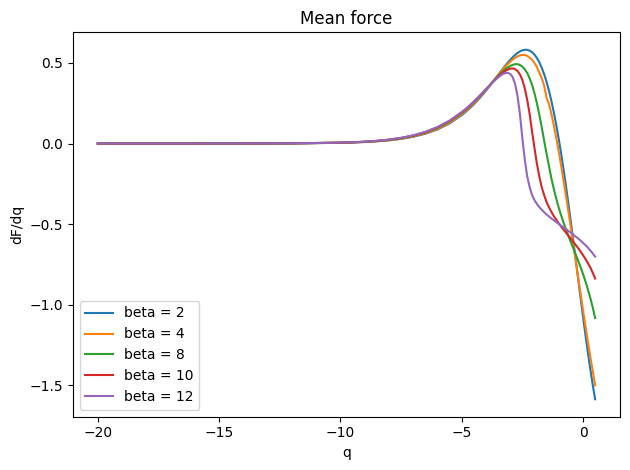

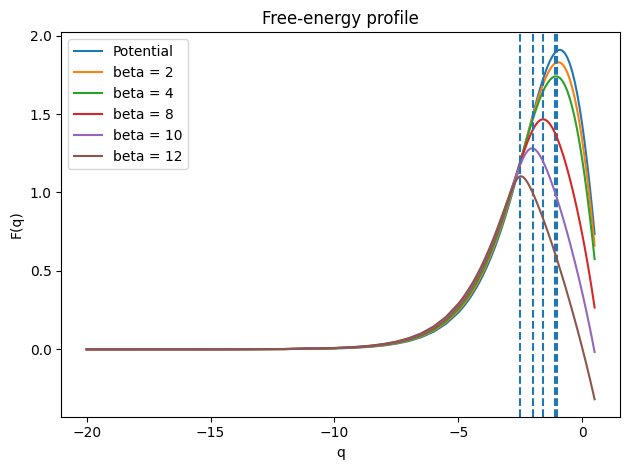

In [35]:
for i, beta in enumerate(beta_range_asym):
    dFdq = dFdq_list_asym[i]
    plt.plot(q_grid_asym, dFdq, label=f'beta = {beta}')
plt.xlabel("q"); plt.ylabel("dF/dq")
plt.title("Mean force")
plt.tight_layout()
plt.legend()
plt.show()

plt.plot(q_grid_asym, V_asym_eckart(q_grid_asym), label='Potential')
for i, beta in enumerate(beta_range_asym):
    F_profile = F_profile_asym[i]
    plt.plot(q_grid_asym, F_profile, label=f'beta = {beta}')
    plt.axvline(q_dag_asym[i], ls='--')
plt.xlabel("q"); plt.ylabel("F(q)")
plt.title("Free-energy profile")
plt.tight_layout()
plt.legend()
plt.show()

### Ring Polymer

In [37]:
n_list = [16,32,64,100,128]
q_dag_asym = np.load('Results/q_dag_asym.npy')
q_dagger_test_asym = np.array([
    [-3,    -2,     -1,     0,      0.4 ],           # beta = 2, true dividing surface q‡ = -1.0
    [-3,    -2,     -1.1,   0,      0.4 ],           # beta = 4, true dividing surface q‡ = -1.1
    [-3,    -2,     -1.6,   -1,     -0.5],           # beta = 8, true dividing surface q‡ = -1.6
    [-3,    -2.5,   -2,     -1.5,   -1.0],           # beta = 10, true dividing surface q‡ = -2.0
    [-3.3,  -3,     -2.5,   -2,     -1.5]            # beta = 12, true dividing surface q‡ = -2.5
])

C_time_poly_asym = []
C_func_poly_asym = []

for i, beta in enumerate(beta_range_asym):
    C_time_poly_asym.append([])
    C_func_poly_asym.append([])
    n = n_list[i]

    for q_dagger in q_dagger_test_asym[i]:
        C_time, C_func = Polymer_Cfs(
            q_dagger, 2, 100000, beta, n, hbar_nat, m_nat, eq_t_end=2.5, eq_delta_t=0.25, t_end=15, delta_t=0.15, force = F_asym_eckart
        )

        C_time_poly_asym[i].append(C_time)
        C_func_poly_asym[i].append(C_func)

np.save('Results/C_time_poly_asym.npy', C_time_poly_asym)
np.save('Results/C_func_poly_asym.npy', C_func_poly_asym)

100%|██████████| 100000/100000 [02:03<00:00, 807.06it/s]


------Beta = 2.0------
k_RPMD = 7.230782e-03
kappa = 1.168878e+00
-----------------------
------Beta = 4.0------
k_RPMD = 1.855720e-04
kappa = 1.931388e+00
-----------------------
------Beta = 8.0------
k_RPMD = 8.778777e-07
kappa = 2.705955e+01
-----------------------
------Beta = 10.0------
k_RPMD = 1.942109e-07
kappa = 3.038158e+02
-----------------------
------Beta = 12.0------
k_RPMD = 7.179553e-08
kappa = 5.638582e+03
-----------------------


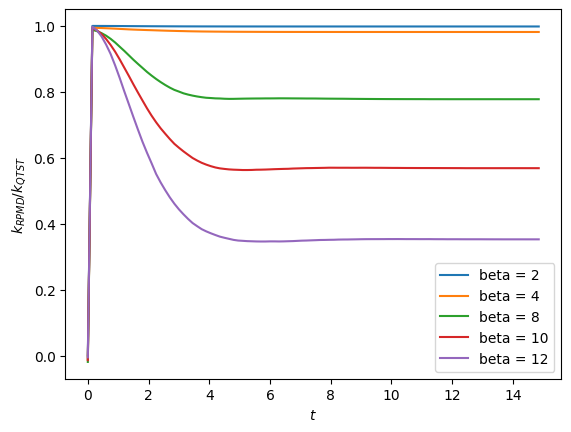

In [38]:
k_RPMD_asym = np.zeros(len(beta_range_asym))
kappa_RPMD_asym = np.zeros(len(beta_range_asym))

C_time_poly_asym = np.load('Results/C_time_poly_asym.npy')
C_func_poly_asym = np.load('Results/C_func_poly_asym.npy')

for i, beta in enumerate(beta_range_asym):
    dFdq = dFdq_list_asym[i]
    F_profile = integrate.cumulative_trapezoid(dFdq, q_grid_asym, initial=0.0)
    C_den = np.sqrt(1.0 / (2.0 * np.pi * m_nat * beta))

    q_dagger = q_dag_asym[i]
    j0 = np.argmin(np.abs(q_dagger_test_asym[i] - q_dagger))
    C_time = C_time_poly_asym[i, j0]
    C_func = C_func_poly_asym[i, j0]

    i0 = np.argmin(np.abs(q_grid_asym - q_dagger))
    DeltaF = F_profile[i0] - F_profile[0]
    k_QTST = np.exp(-beta * DeltaF) / np.sqrt(2.0 * np.pi * m_nat * beta)
    
    k_cl = k_cl_asym[i]
    k_RPMD = k_QTST * C_func[-1] / C_den
    k_RPMD_asym[i] = k_RPMD
    kappa = k_RPMD/k_cl
    kappa_RPMD_asym[i] = kappa
    plt.plot(C_time, C_func/C_den, label=f'beta = {beta}')
    print(f'------Beta = {beta:.1f}------')
    print(f"k_RPMD = {k_RPMD:.6e}")
    print(f"kappa = {kappa:.6e}")
    print('-----------------------')
plt.xlabel(r'$t$')
plt.ylabel(r'$k_{RPMD}/k_{QTST}$')
plt.legend()

------Beta = 2.0------


k_RPMD = 7.172445e-03
kappa = 1.159448e+00
k_RPMD = 7.139783e-03
kappa = 1.154168e+00
k_RPMD = 7.230782e-03
kappa = 1.168878e+00
k_RPMD = 7.049220e-03
kappa = 1.139528e+00
k_RPMD = 7.486473e-03
kappa = 1.210211e+00
--------------------------------


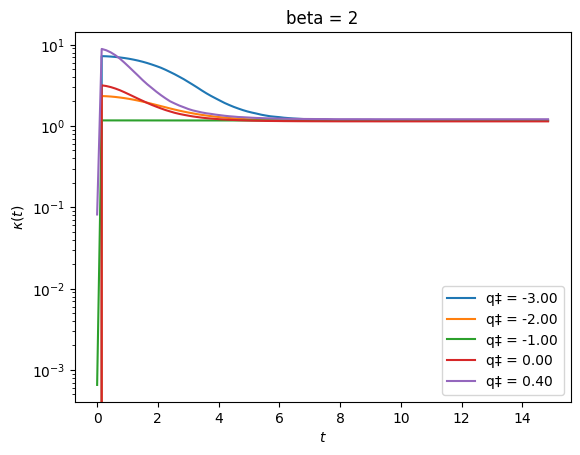

------Beta = 4.0------
k_RPMD = 1.783519e-04
kappa = 1.856243e+00
k_RPMD = 1.899358e-04
kappa = 1.976806e+00
k_RPMD = 1.855720e-04
kappa = 1.931388e+00
k_RPMD = 1.800773e-04
kappa = 1.874200e+00
k_RPMD = 1.552149e-04
kappa = 1.615439e+00
--------------------------------


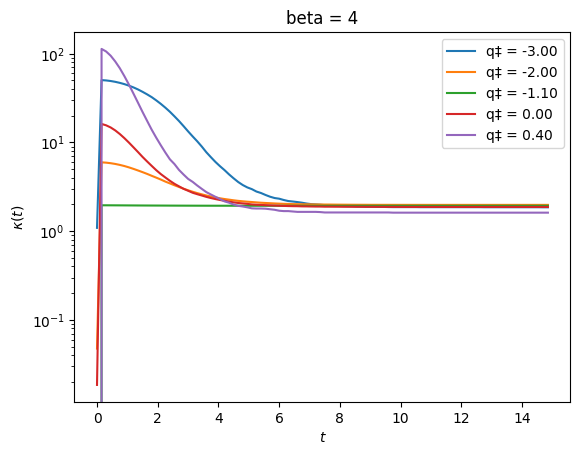

------Beta = 8.0------
k_RPMD = 9.695080e-07
kappa = 2.988394e+01
k_RPMD = 8.945301e-07
kappa = 2.757284e+01
k_RPMD = 8.778777e-07
kappa = 2.705955e+01
k_RPMD = 9.060835e-07
kappa = 2.792896e+01
k_RPMD = 9.013894e-07
kappa = 2.778427e+01
--------------------------------


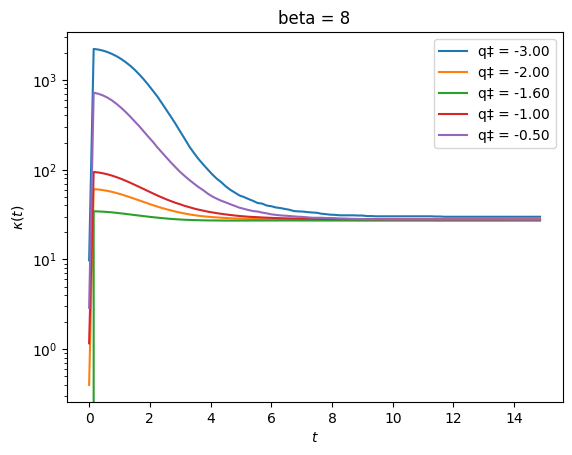

------Beta = 10.0------
k_RPMD = 2.162819e-07
kappa = 3.383428e+02
k_RPMD = 1.903587e-07
kappa = 2.977896e+02
k_RPMD = 1.942109e-07
kappa = 3.038158e+02
k_RPMD = 1.990613e-07
kappa = 3.114035e+02
k_RPMD = 1.641619e-07
kappa = 2.568082e+02
--------------------------------


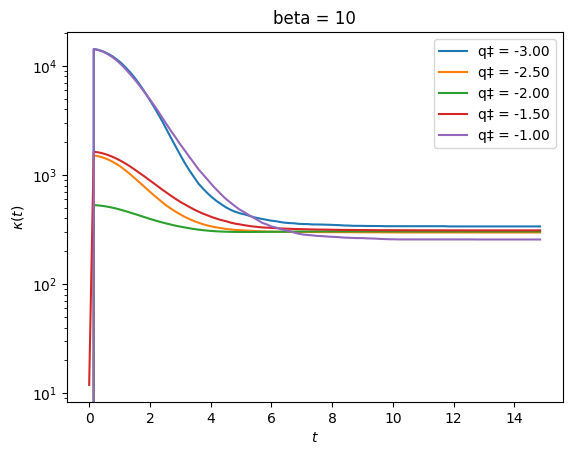

------Beta = 12.0------
k_RPMD = 6.381990e-08
kappa = 5.012202e+03
k_RPMD = 7.081217e-08
kappa = 5.561352e+03
k_RPMD = 7.179553e-08
kappa = 5.638582e+03
k_RPMD = 7.107522e-08
kappa = 5.582011e+03
k_RPMD = 3.455052e-08
kappa = 2.713482e+03
--------------------------------


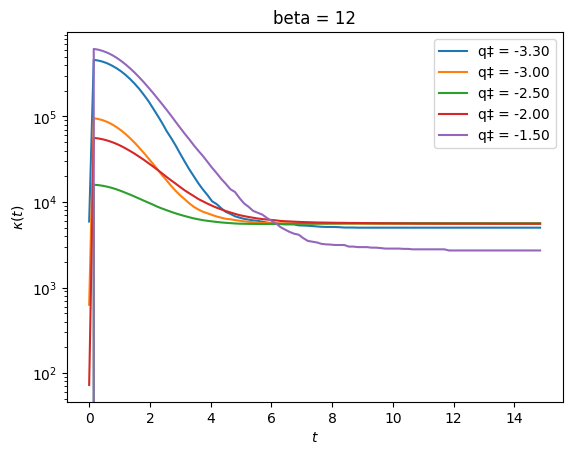

In [39]:
k_RPMD_all_asym = np.zeros_like(q_dagger_test_asym)
kappa_RPMD_all_asym = np.zeros_like(q_dagger_test_asym)


for i, beta in enumerate(beta_range_asym):
    dFdq = dFdq_list_asym[i]
    F_profile = integrate.cumulative_trapezoid(dFdq, q_grid_asym, initial=0.0)
    
    C_den = np.sqrt(1.0 / (2.0 * np.pi * m_real * beta))
    print(f'------Beta = {beta:.1f}------')
    for j, q_dagger in enumerate(q_dagger_test_asym[i]):
        C_time = C_time_poly_asym[i, j]
        C_func = C_func_poly_asym[i, j]

        i0 = np.argmin(np.abs(q_grid_asym - q_dagger))
        DeltaF = F_profile[i0] - F_profile[0]
        k_QTST = np.exp(-beta * DeltaF) / np.sqrt(2.0 * np.pi * m_real * beta)
        
        k_RPMD = k_QTST * C_func[-1] / C_den
        k_RPMD_all_asym[i, j] = k_RPMD
        k_cl = k_cl_asym[i]
        kappa = k_RPMD / k_cl
        kappa_RPMD_all_asym[i, j] = kappa

        kappa_t = k_QTST * C_func / (C_den * k_cl)
        plt.plot(C_time, kappa_t, label=f'q‡ = {q_dagger:.2f}')
        print(f"k_RPMD = {k_RPMD:.6e}")
        print(f"kappa = {kappa:.6e}")
    print('--------------------------------')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\kappa(t)$')
    plt.title(f'beta = {beta}')
    plt.legend()
    plt.yscale('log')
    plt.show()

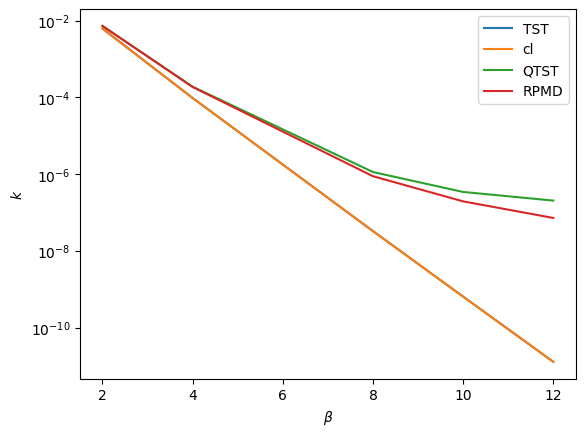

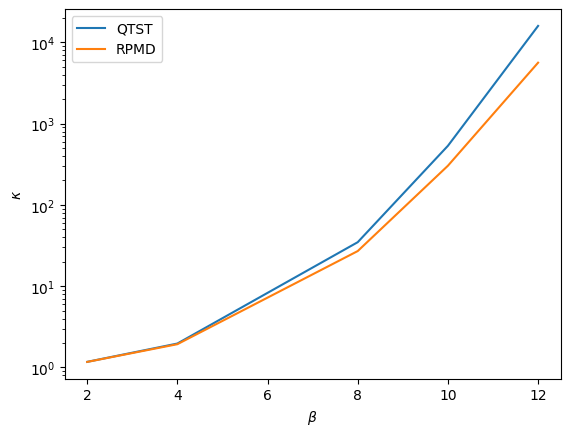

In [40]:
plt.plot(beta_range_asym, k_TST_asym, label='TST')
plt.plot(beta_range_asym, k_cl_asym, label='cl')
plt.plot(beta_range_asym, k_QTST_asym, label='QTST')
plt.plot(beta_range_asym, k_RPMD_asym, label='RPMD')
plt.yscale('log')
plt.xlabel(r"$\beta$")
plt.ylabel(r"$k$")
plt.legend()
plt.show()

plt.plot(beta_range_asym, kappa_QTST_asym, label='QTST')
plt.plot(beta_range_asym, kappa_RPMD_asym, label='RPMD')
plt.yscale('log')
plt.ylabel(r'$\kappa$')
plt.xlabel(r"$\beta$")
plt.legend()

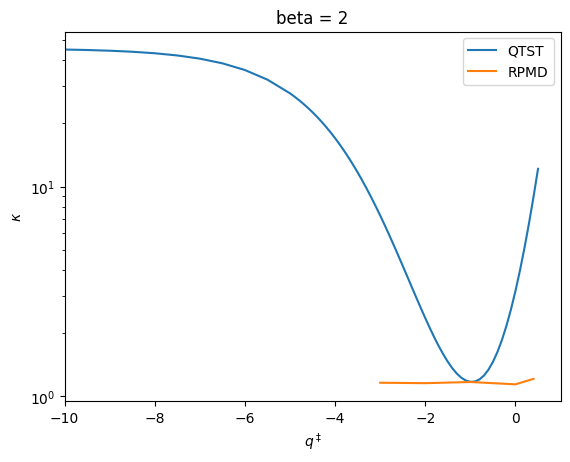

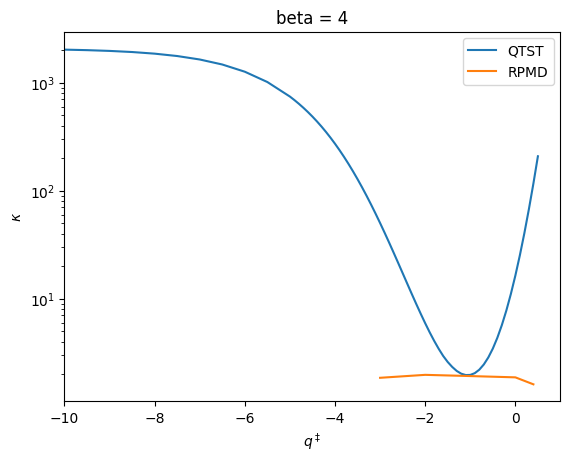

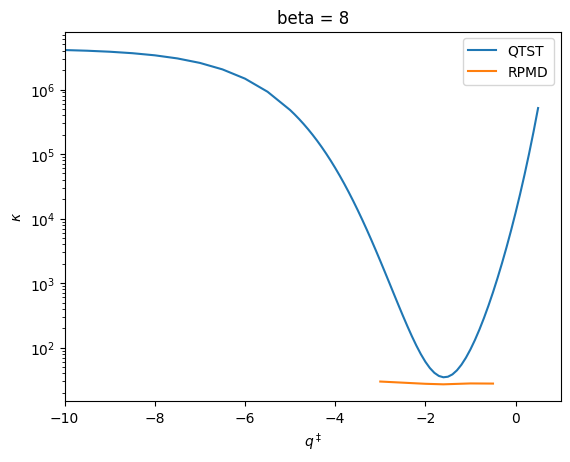

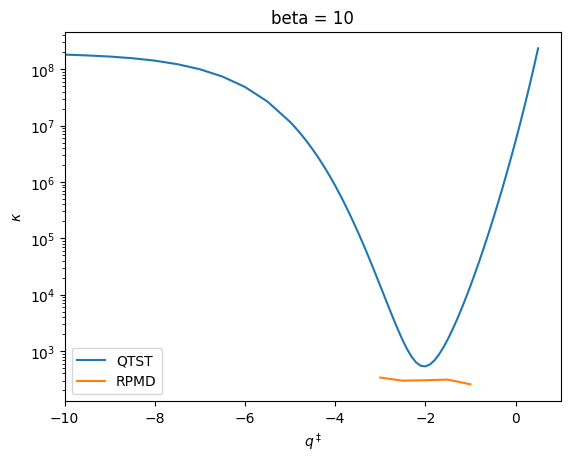

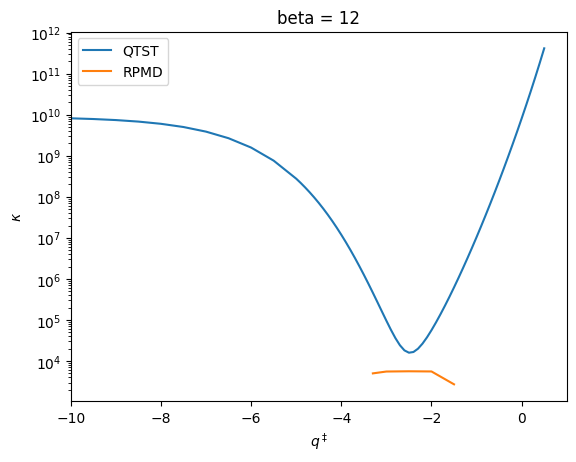

In [41]:
for i, dFdq in enumerate(dFdq_list_asym):
    beta = beta_range_asym[i]

    F_profile = F_profile_asym[i]

    DeltaF_qdag = F_profile - F_profile[0]
    k_QTST_qdag = np.exp(-beta * DeltaF_qdag) / np.sqrt(2.0 * np.pi * m_nat * beta)

    k_RPMD = k_RPMD_asym[i]
    k_cl = k_cl_asym[i]
    kappa_QTST = k_QTST_qdag / k_cl
    kappa_RPMD = k_RPMD / k_cl
    plt.plot(q_grid_asym, kappa_QTST, label='QTST')
    plt.plot(q_dagger_test_asym[i], kappa_RPMD_all_asym[i], label='RPMD')
    plt.ylabel(r'$\kappa$')
    plt.xlabel(r'$q^\ddagger$')
    plt.title(f'beta = {beta}')
    plt.yscale('log')
    plt.legend()
    plt.xlim(-10,1)
    plt.show()